# Heart Disease Dataset Analysis

Dataset taken from: https://archive.ics.uci.edu/dataset/45/heart+disease

#### Data Dictionary:
* Age: Age in years
* sex: 1 for male and 0 for female
* cp: chest pain type
    * 1: typical angina,
    * 2: atypical angina,
    * 3: non-anginal pain,
    * 4: asymptomatic.
* resting_blood_pressure: resting blood pressure in mm Hg while admitted to admitted. Above 130 is considered to be concerning
* serum_Choleresterol: in mg/dl
* fasting_blood_sugar>120: fasting blood sugar > 120 mg/dl (1 is True; 0 is False)
* restECG: resting electrocardiographic result where 0 is nothing to note, 1: ST-T wave abnormality with mild to severe problems, signal non-normal heart beat.
* maximum_heart_rate: Maximum heart rate achieved in beats per minute.
* exercise_induced_angina: 1 for yes; 0 for no
* oldpeak: ST depression induced by exercise relative to rest. Analyzes stress of heart during exercise.
* slope: slope of the peak exercise ST segment.
    * 1: upsloping: better heart rate with exercise (uncommon),
    * 2: Flatsloping: minimal change (typical healthy heart)
    * 3: Downsloping
* ca: Number of major vessels (0-3) colored by flouroscopy colored vessel indicate doctor can see the bloof passing through. The more blood movement, the better results (indicating no clots)
* thal: Thalium stress result. 
    * 1,3 for normal; 
    * 6 for fixed defect: used to be defect but fine now. 
    * 7: reversable defect: no proper blood movement when exercising.
* Target: num or outcome variable for diagnosis of disease.

In [1]:
# !pip install mysql-connector-python

# import modules
import random
from datetime import datetime
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Creating Database heart_disease with 3 tables (patients, demographics, and medical_records)

In [2]:
# Database credentials
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'Ss073121#'
}

# Connect to MySQL server
conn = mysql.connector.connect(**db_config)
cursor = conn.cursor()

# Create database
cursor.execute("CREATE DATABASE IF NOT EXISTS heart_disease")
cursor.execute("USE heart_disease")

# Create patients table
cursor.execute("""
CREATE TABLE IF NOT EXISTS patients (
    patient_id INT AUTO_INCREMENT PRIMARY KEY,
    name VARCHAR(100),
    gender CHAR(1),
    birth_date DATE
)
""")

# Create demographics table
cursor.execute("""
CREATE TABLE IF NOT EXISTS demographics (
    patient_id INT,
    ethnicity VARCHAR(50),
    smoker BOOLEAN,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")

# Create medical_records table
cursor.execute("""
CREATE TABLE IF NOT EXISTS medical_records (
    patient_id INT,
    age INT,
    chest_pain VARCHAR(50),
    trestbps INT,
    chol INT,
    fasting_blood_sugar VARCHAR(5),
    restecg VARCHAR(50),
    thalach INT,
    exang VARCHAR(3),
    oldpeak FLOAT,
    slope VARCHAR(50),
    ca INT,
    thal VARCHAR(50),
    target INT,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")

# Commit changes and close connection
conn.commit()

### Reading data from UCI repository for the heart-disease data

In [3]:
# Connect to MySQL 

# Database credentials
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'Ss073121#',
    'database': 'heart_disease'
}

# Connect to MySQL server
conn = mysql.connector.connect(**db_config)
cursor = conn.cursor()

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]
df = pd.read_csv(url, header=None, names=columns, na_values='?')

In [4]:
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [5]:
df.shape

(303, 14)

### Data Cleaning steps after extracting from UCI repository

In [6]:
# Data Cleaning
# Drop rows with any missing values
df = df.dropna()

# Convert appropriate columns to correct types
df = df.astype({
    'age': 'int', 'sex': 'int', 'trestbps': 'int', 'chol': 'int',
    'thalach': 'int', 'ca': 'int', 'target': 'int'
})
df['oldpeak'] = df['oldpeak'].astype(float)

# Map numerical values to descriptive strings
df['cp'] = df['cp'].map({1: 'Typical Angina', 2: 'Atypical Angina', 3: 'Non-Anginal Pain', 4: 'Asymptomatic'})
df['fbs'] = df['fbs'].map({0: 'False', 1: 'True'})
df['restecg'] = df['restecg'].map({0: 'Normal', 1: 'ST Elevation', 2: 'Left Ventricular Hypertrophy'})
df['exang'] = df['exang'].map({0: 'No', 1: 'Yes'})
df['slope'] = df['slope'].map({1: 'Upsloping', 2: 'Flat', 3: 'Downsloping'})
df['thal'] = df['thal'].map({3: 'Normal', 6: 'Fixed Defect', 7: 'Reversible Defect'})
df['sex'] = df['sex'].map({1: 'M', 0: 'F'})

#### Load data into the respective tables in the heart_disease db

In [7]:
# Function to generate random birth date based on age
def generate_birth_date(age):
    birth_year = datetime.now().year - age
    birth_date = datetime(birth_year, random.randint(1, 12), random.randint(1, 28)).date()
    return birth_date

# List of ethnicities to choose from
ethnicities = ['Caucasian', 'African American', 'Asian', 'Hispanic', 'Other']

# Insert patients and related records
for index, row in df.iterrows():
    # Insert into patients table
    name = f"Patient_{index+1}"
    birth_date = generate_birth_date(row['age'])
    gender = row['sex']
    cursor.execute("INSERT INTO patients (name, gender, birth_date) VALUES (%s, %s, %s)", (name, gender, birth_date))
    patient_id = cursor.lastrowid

    # Insert into demographics table
    ethnicity = random.choice(ethnicities)
    smoker = bool(random.getrandbits(1))
    cursor.execute("INSERT INTO demographics (patient_id, ethnicity, smoker) VALUES (%s, %s, %s)", (patient_id, ethnicity, smoker))

    # Insert into medical_records table
    cursor.execute("""
        INSERT INTO medical_records (
            patient_id, age, chest_pain, trestbps, chol, fasting_blood_sugar, restecg, thalach, exang, oldpeak, slope, ca, thal, target
        ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """, (
        patient_id, row['age'], row['cp'], row['trestbps'], row['chol'], row['fbs'], row['restecg'], 
        row['thalach'], row['exang'], row['oldpeak'], row['slope'], row['ca'], row['thal'], row['target']
    ))

conn.commit()

### Retrieving data from heart_disease db and viewing as a dataframes

In [8]:
import warnings
# Suppress the warning
warnings.filterwarnings("ignore", category=UserWarning)

# Select all patients
query="""SELECT * FROM patients"""
patients = pd.read_sql(query,conn)
print(patients.head())

# Select all demographics
query = "SELECT * FROM demographics"
demographics = pd.read_sql(query,conn)
print(demographics.head())

# Select all medical_records
query = "SELECT * FROM medical_records"
medical_records = pd.read_sql(query,conn)
print(medical_records.head())

   patient_id       name gender  birth_date
0           1  Patient_1      M  1961-08-15
1           2  Patient_2      M  1957-08-13
2           3  Patient_3      M  1957-05-05
3           4  Patient_4      M  1987-07-25
4           5  Patient_5      F  1983-06-17
   patient_id         ethnicity  smoker
0           1             Other       0
1           2             Other       0
2           3             Asian       0
3           4             Asian       1
4           5  African American       0
   patient_id  age        chest_pain  trestbps  chol fasting_blood_sugar  \
0           1   63    Typical Angina       145   233                True   
1           2   67      Asymptomatic       160   286               False   
2           3   67      Asymptomatic       120   229               False   
3           4   37  Non-Anginal Pain       130   250               False   
4           5   41   Atypical Angina       130   204               False   

                        restecg  thalac

In [9]:
# Join tables to view detailed information about patients
query = """
    SELECT *
    FROM 
        patients p
    JOIN 
        demographics d ON p.patient_id = d.patient_id
    JOIN 
        medical_records m ON p.patient_id = m.patient_id;
"""
detailed_info = pd.read_sql(query,conn)
detailed_info.head()

,patient_id,name,gender,birth_date,patient_id,ethnicity,smoker,patient_id,age,chest_pain,...,chol,fasting_blood_sugar,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,1,Patient_1,M,1961-08-15,1,Other,0,1,63,Typical Angina,...,233,True,Left Ventricular Hypertrophy,150,No,2.3,Downsloping,0,Fixed Defect,0
1,2,Patient_2,M,1957-08-13,2,Other,0,2,67,Asymptomatic,...,286,False,Left Ventricular Hypertrophy,108,Yes,1.5,Flat,3,Normal,2
2,3,Patient_3,M,1957-05-05,3,Asian,0,3,67,Asymptomatic,...,229,False,Left Ventricular Hypertrophy,129,Yes,2.6,Flat,2,Reversible Defect,1
3,4,Patient_4,M,1987-07-25,4,Asian,1,4,37,Non-Anginal Pain,...,250,False,Normal,187,No,3.5,Downsloping,0,Normal,0
4,5,Patient_5,F,1983-06-17,5,African American,0,5,41,Atypical Angina,...,204,False,Left Ventricular Hypertrophy,172,No,1.4,Upsloping,0,Normal,0


In [10]:
# Finding the Average Cholesterol Level by Gender
query = """ 
SELECT 
        p.gender,
        AVG(m.chol) AS average_cholesterol
    FROM 
        patients p
    JOIN 
        medical_records m ON p.patient_id = m.patient_id
    GROUP BY 
        p.gender;
"""
avg_gender_chol = pd.read_sql(query,conn)
avg_gender_chol.head()

,gender,average_cholesterol
0,M,240.2438
1,F,262.2292


In [11]:
# Find the Maximum, Minimum, and Average Heart Rate by Age Group
query = """
SELECT 
    CASE 
        WHEN m.age BETWEEN 30 AND 39 THEN '30-39'
        WHEN m.age BETWEEN 40 AND 49 THEN '40-49'
        WHEN m.age BETWEEN 50 AND 59 THEN '50-59'
        WHEN m.age BETWEEN 60 AND 69 THEN '60-69'
        ELSE '70+' 
    END AS age_group,
    MAX(m.thalach) AS max_heart_rate,
    MIN(m.thalach) AS min_heart_rate,
    AVG(m.thalach) AS avg_heart_rate
FROM 
    medical_records m
GROUP BY 
    age_group
ORDER BY 
    age_group;
"""
max_min_avg_hr = pd.read_sql(query,conn)
max_min_avg_hr.head()

,age_group,max_heart_rate,min_heart_rate,avg_heart_rate
0,30-39,192,130,169.2308
1,40-49,194,114,159.5211
2,50-59,195,88,148.0909
3,60-69,179,71,141.7160
4,70+,202,109,137.0000


In [12]:
# Find Patients with above average Resting Blood Pressure
query = """
SELECT 
    p.patient_id,
    p.gender,
    p.birth_date,
    m.age,
    m.trestbps
FROM 
    patients p
JOIN 
    medical_records m ON p.patient_id = m.patient_id
WHERE 
    m.trestbps > (SELECT AVG(trestbps) FROM medical_records)
ORDER BY 
    m.trestbps DESC;
"""
above_avg_restbp = pd.read_sql(query,conn)
above_avg_restbp.head()

,patient_id,gender,birth_date,age,trestbps
0,126,F,1968-03-14,56,200
1,423,F,1968-07-27,56,200
2,720,F,1968-07-23,56,200
3,1017,F,1968-08-12,56,200
4,187,M,1970-09-14,54,192


In [13]:
# Identifying high risk patients for developing heart diseases based on data
query = """
SELECT *
FROM 
    patients p
JOIN 
    medical_records m ON p.patient_id = m.patient_id
WHERE 
    m.target >= 2
ORDER BY 
    m.target DESC, m.age ASC;
"""
high_risk_patients = pd.read_sql(query,conn)
high_risk_patients.head()

,patient_id,name,gender,birth_date,patient_id,age,chest_pain,trestbps,chol,fasting_blood_sugar,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,209,Patient_212,M,1986-09-05,209,38,Typical Angina,120,231,False,Normal,182,Yes,3.8,Flat,0,Reversible Defect,4
1,506,Patient_212,M,1986-01-16,506,38,Typical Angina,120,231,False,Normal,182,Yes,3.8,Flat,0,Reversible Defect,4
2,803,Patient_212,M,1986-10-19,803,38,Typical Angina,120,231,False,Normal,182,Yes,3.8,Flat,0,Reversible Defect,4
3,1100,Patient_212,M,1986-04-13,1100,38,Typical Angina,120,231,False,Normal,182,Yes,3.8,Flat,0,Reversible Defect,4
4,48,Patient_48,M,1974-01-28,48,50,Asymptomatic,150,243,False,Left Ventricular Hypertrophy,128,No,2.6,Flat,0,Reversible Defect,4


### Data analysis and visualization with Python  

In [14]:
# Basic statistical analysis on the dataset
mean_age = df['age'].mean()
median_chol = df['chol'].median()
std_thalach = df['thalach'].std()

print(f"Mean Age: {round(mean_age, 2)}")
print(f"Median Cholesterol Level: {median_chol}")
print(f"Standard Deviation of Maximum Heart Rate: {round(std_thalach, 2)}")

Mean Age: 54.54
Median Cholesterol Level: 243.0
Standard Deviation of Maximum Heart Rate: 22.94


In [16]:
# Create bins for age groups
bins = [29, 39, 49, 59, 69, 79]
labels = ['30-39', '40-49', '50-59', '60-69', '70-79']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Calculate average heart rate (thalach) by age group
avg_thalach_by_age_group = df.groupby('age_group')['thalach'].mean().reset_index()

print("Average Heart Rate by Age Group:")
print(avg_thalach_by_age_group)

Average Heart Rate by Age Group:
  age_group     thalach
0     30-39  174.900000
1     40-49  160.257143
2     50-59  148.339286
3     60-69  142.576087
4     70-79  133.307692


In [18]:
# Grouping by Age Group and calculating the average cholesterol
avg_chol_by_age_group = df.groupby('age_group')['chol'].mean().reset_index()

print("Average Cholesterol by Age Group:")
print(round(avg_chol_by_age_group, 2))

Average Cholesterol by Age Group:
  age_group    chol
0     30-39  214.70
1     40-49  236.43
2     50-59  248.66
3     60-69  257.53
4     70-79  247.92


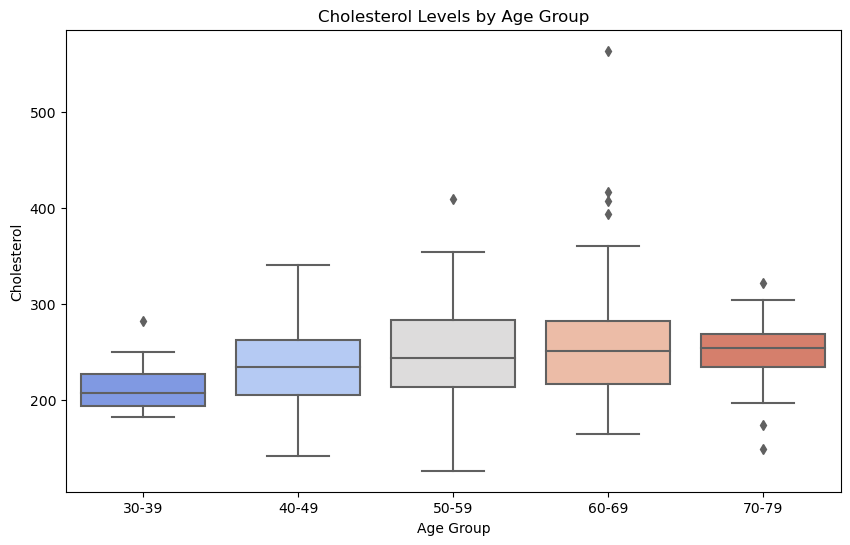

In [19]:
# Box plot of Cholesterol levels by Age Group
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='age_group', y='chol', palette='coolwarm')
plt.title('Cholesterol Levels by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Cholesterol')
plt.show()

In [21]:
# Grouping by Age Group and Gender, and calculating the average cholesterol
avg_chol_by_age_group_gender = df.groupby(['age_group', 'sex'])['chol'].mean().reset_index()

print("Average Cholesterol by Age Group and Gender:")
print(round(avg_chol_by_age_group_gender, 2))

Average Cholesterol by Age Group and Gender:
  age_group sex    chol
0     30-39   F  202.67
1     30-39   M  219.86
2     40-49   F  228.16
3     40-49   M  239.51
4     50-59   F  272.06
5     50-59   M  238.46
6     60-69   F  281.18
7     60-69   M  243.67
8     70-79   F  236.83
9     70-79   M  257.43


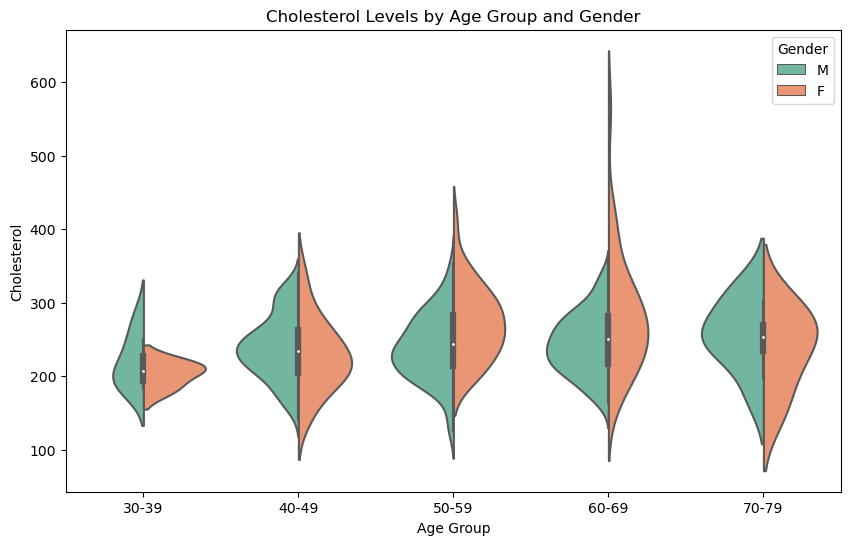

In [22]:
# Violin Plot of Cholesterol Levels by Age Group and Gender
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='age_group', y='chol', hue='sex', split=True, palette='Set2')
plt.title('Cholesterol Levels by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Cholesterol')
plt.legend(title='Gender')
plt.show()

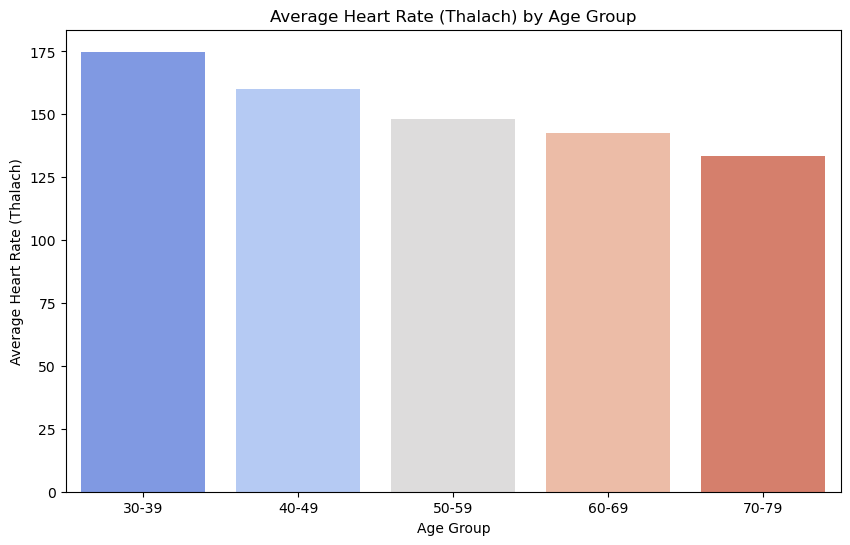

In [23]:
# Bar plot for Average Heart Rate (Thalach) by Age Group
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_thalach_by_age_group, x='age_group', y='thalach', palette='coolwarm')
plt.title('Average Heart Rate (Thalach) by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Heart Rate (Thalach)')
plt.show()

In [24]:
# Correlation between age and maximum heart rate (thalach)
correlation = df[['age', 'thalach']].corr().iloc[0, 1]
print(f"Correlation between Age and Maximum Heart Rate: {round(correlation,3)}")

Correlation between Age and Maximum Heart Rate: -0.395


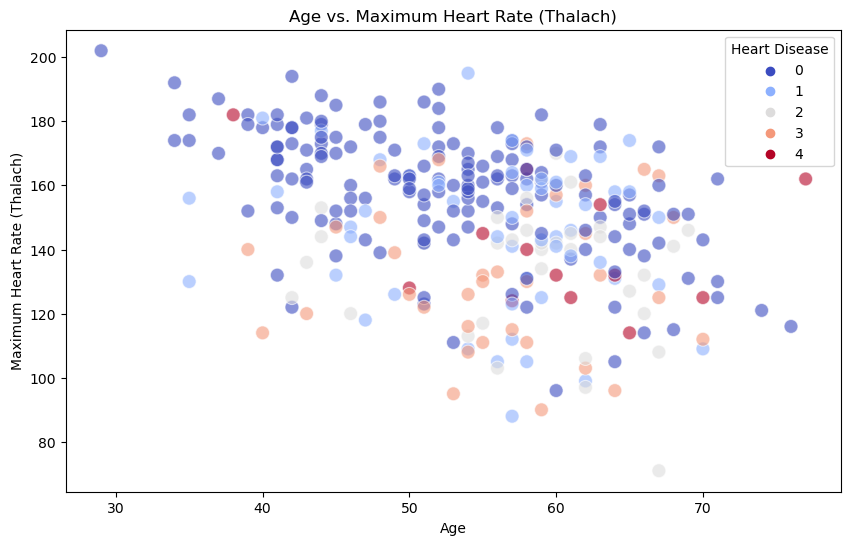

In [25]:
# Scatter plot of Age vs. Maximum Heart Rate (thalach)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='thalach', hue='target', palette='coolwarm', s=100, alpha=0.6)
plt.title('Age vs. Maximum Heart Rate (Thalach)')
plt.xlabel('Age')
plt.ylabel('Maximum Heart Rate (Thalach)')
plt.legend(title='Heart Disease')
plt.show()

Based on the color coding scheme of the plot, very less number of patients will develop the heart diseases.

In [26]:
# Identifying high-risk patients and calculating average cholesterol by gender
high_risk_patients = df[df['target'] > 0]

avg_chol_high_risk_by_gender = high_risk_patients.groupby('sex')['chol'].mean().reset_index()

print("Average Cholesterol of High-Risk Patients by Gender:")
print(round(avg_chol_high_risk_by_gender, 2))

# Filter patients who are older than 50, have high cholesterol, and show signs of heart disease (target > 0)
filtered_df = df[(df['age'] > 50) & (df['chol'] > 240) & (df['target'] > 0)]

#filtered_df['gender'] = filtered_df['sex'].map({1: 'M', 0: 'F'})

# Display the filtered DataFrame
print("Filtered DataFrame (Age > 50, Chol > 240, Heart Disease):\n", filtered_df.head())

Average Cholesterol of High-Risk Patients by Gender:
  sex    chol
0   F  276.16
1   M  246.43
Filtered DataFrame (Age > 50, Chol > 240, Heart Disease):
     age sex                cp  trestbps  chol    fbs  \
1    67   M      Asymptomatic       160   286  False   
6    62   F      Asymptomatic       140   268  False   
8    63   M      Asymptomatic       130   254  False   
12   56   M  Non-Anginal Pain       130   256   True   
22   58   M   Atypical Angina       120   284  False   

                         restecg  thalach exang  oldpeak        slope  ca  \
1   Left Ventricular Hypertrophy      108   Yes      1.5         Flat   3   
6   Left Ventricular Hypertrophy      160    No      3.6  Downsloping   2   
8   Left Ventricular Hypertrophy      147    No      1.4         Flat   1   
12  Left Ventricular Hypertrophy      142   Yes      0.6         Flat   1   
22  Left Ventricular Hypertrophy      160    No      1.8         Flat   0   

                 thal  target age_group  
1   

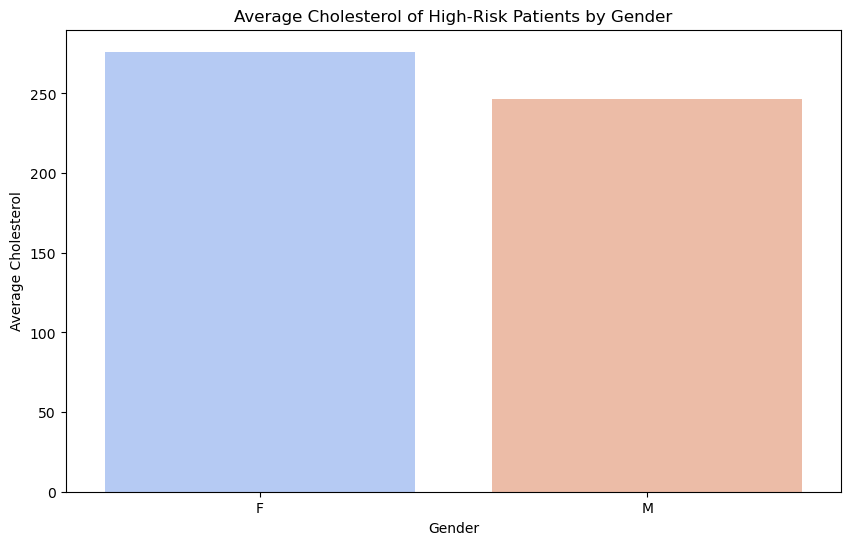

In [27]:
# Bar plot of Average Cholesterol of High-Risk Patients by Gender
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_chol_high_risk_by_gender, x='sex', y='chol', palette='coolwarm')
plt.title('Average Cholesterol of High-Risk Patients by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Cholesterol')
plt.show()

In [28]:
# Define a custom function to categorize cholesterol levels
def cholesterol_category(chol):
    if chol < 200:
        return 'Desirable'
    elif 200 <= chol < 240:
        return 'Borderline High'
    else:
        return 'High'

# Apply the custom function to the 'chol' column
df['Chol_Category'] = df['chol'].apply(cholesterol_category)

# Create age groups
age_bins = [29, 39, 49, 59, 69, 79]
age_labels = ['30-39', '40-49', '50-59', '60-69', '70-79']
df['Age_Group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Group by sex (assuming 1: Male, 0: Female), cholesterol category, and age group
chol_avg_by_sex_age_category = df.groupby(['sex', 'Age_Group', 'Chol_Category']).agg(
    Average_Cholesterol=('chol', 'mean'),
    Count=('chol', 'size')
).reset_index()

# Fill NaN values with 0 (if necessary, but should not be needed here)
chol_avg_by_sex_age_category['Average_Cholesterol'].fillna(0, inplace=True)
chol_avg_by_sex_age_category['Count'].fillna(0, inplace=True)

print("Average Cholesterol Levels and Count by Sex, Age Group, and Cholesterol Category:")
print(chol_avg_by_sex_age_category)

Average Cholesterol Levels and Count by Sex, Age Group, and Cholesterol Category:
   sex Age_Group    Chol_Category  Average_Cholesterol  Count
0    F     30-39  Borderline High           212.500000      2
1    F     30-39        Desirable           183.000000      1
2    F     30-39             High             0.000000      0
3    F     40-49  Borderline High           217.142857      7
4    F     40-49        Desirable           175.000000      5
5    F     40-49             High           277.142857      7
6    F     50-59  Borderline High           219.142857      7
7    F     50-59        Desirable           196.500000      2
8    F     50-59             High           292.920000     25
9    F     60-69  Borderline High           220.333333      6
10   F     60-69        Desirable           183.500000      4
11   F     60-69             High           312.666667     24
12   F     70-79  Borderline High           239.000000      1
13   F     70-79        Desirable           173.00

In [29]:
# Determine the number and proportion of patients with high cholesterol who have heart disease.
# High cholesterol and heart disease
high_cholesterol = df[df['chol'] > 240]
high_chol_heart_disease = high_cholesterol.groupby('target').size().reset_index(name='count')
high_chol_heart_disease['proportion'] = high_chol_heart_disease['count'] / high_chol_heart_disease['count'].sum()
print(high_chol_heart_disease)

   target  count  proportion
0       0     72    0.476821
1       1     32    0.211921
2       2     21    0.139073
3       3     20    0.132450
4       4      6    0.039735


In [30]:
# Relationship Between Cholesterol and Heart Disease
# Compare the average cholesterol levels between patients with and without heart disease.
avg_chol_by_heart_disease = df.groupby('target')['chol'].mean().reset_index()
avg_chol_by_heart_disease.columns = ['heart_disease', 'average_cholesterol']
print(avg_chol_by_heart_disease)

   heart_disease  average_cholesterol
0              0           243.493750
1              1           249.148148
2              2           260.857143
3              3           246.457143
4              4           253.384615


In [31]:
# Average Values of Key Variables by Chest Pain Type
# Calculate the average values of key variables like age, cholesterol, and maximum heart rate for each type of chest pain.
avg_values_by_chest_pain_type = df.groupby('cp').agg({'age': 'mean', 'chol': 'mean', 'thalach': 'mean'}).reset_index()
avg_values_by_chest_pain_type.columns = ['chest_pain_type', 'average_age', 'average_cholesterol', 'average_thalach']
print(avg_values_by_chest_pain_type)

    chest_pain_type  average_age  average_cholesterol  average_thalach
0      Asymptomatic    55.838028           250.866197       140.556338
1   Atypical Angina    51.224490           245.285714       162.795918
2  Non-Anginal Pain    53.915663           245.385542       155.518072
3    Typical Angina    55.869565           237.130435       155.956522


### Tableau Dashboard link to view Visualization Dashbaord: https://public.tableau.com/app/profile/shipra.vinod.gupta/viz/heart_disease_dashboard_17161870526720/HeartDiseaseDashboard?publish=yes